## 순환 신경망을 이용한 문장 생성 예제

**Simple RNN, GRU, LSTM 활용**

**진행하시면서 a를 채워넣어 주세요**

Simple RNN, GRU, LSTM 각 세 개의 문장 생성 모델을 학습하여 생성된 문장과 validation loss를 확인한다. 

학습 데이터는 영문으로 작성된 자연어 문장으로, a개의 문장과 a개의 단어로 구성된다.

<br>

데이터 분석 과정에서 a% 문장이 a개의 단어로 이루어져있으며, 단어는 대체로 a자 이하이며, 그 이상의 단어는 감탄사나 여러 단어가 합쳐진 것을 확인하였다. 

따라서 전처리 과정에서 a개 이상,a개 이하의 단어로 구성된 문장과 a자 이하의 글자 수로 된 단어만을 추출하였다. 

<br>

토크나이저의 단어 사전은 a개로 설정하였다. Simple RNN, LSTM, GRU 모델 모두 a차원의 임베딩 레이어, a개 유닛의 RNN 레이어, a% 비율의 드롭아웃 레이어, 배치 정규화 레이어 순으로 설계하였다. 

옵티마이저는 Adam을 사용하였으며, 학습 데이터 a개를 배치사이즈로 설정하고 각 모델 모두 동일하게 적용하였다. 

<br>

각 모델을 학습한 결과 Simple RNN 모델에서는 epoch a에서 validation loss가 a였다.

Simple RNN 학습 결과의 특이사항으로는 단어사전에 추가되지 못한 토큰인 <unk>가 생성 문장에 자주 등장하였다. 

또한, 해당 토큰이 주로 '명사' 자리에 위치하였다. GRU 모델에서는 validation loss가epoch a에서 a였다. 

GRU 학습 결과의 특이사항으로는 LSTM에 비해 적은 파라미터를 이용함에도 불구하고 좋은 결과를 제시해 주었다. LSTM 모델에서는 epoch a에서 a로 세모델 중 가장 낮은 validationo loss를 획득하였다.

## 서론


본 예제는 Simple RNN과 GRU, LSTM을 사용한 세 개의 문장생성 모델을 이용하여 validation loss와 문장생성 능력을 확인한다. 

RNN 즉, 재귀 신경망은 마르코프 체인과 함께 문장 생성 알고리즘 중 하나이며, 시간 순서를 가진 데이터를 다룰 수 있다는 특성을 가지고 있는 것으로 Simple RNN과 이를 개량한 LSTM, GRU가 있다

<br>


학습 데이터는 영문으로 된 자연어 문장으로 모델의 학습에 앞서 분석과 전처리 과정을 거친다. 

이후 각 모델을 생성하여 validation loss와 생성된 문장을 확인하고자 한다. 다음은 본 예제 진행 순서를 제시한 것이다.

>학습 데이터 분석

>학습 데이터 정제 및 토크나이저 생성

>문장 생성 모델 생성

>모델 학습 및 생성 문장 확인



## 학습 데이터 분석

먼저, 모델을 학습하기 위한 학습 데이터를 분석한다. 


데이터는 텍스트 파일로 자연어로 된 여러 문장으로 구성되어있다. 학습 데이터를 분석하기 위해 데이터 수와 같은 기본 적인 사항을 알아보고 이후, 데이터를 문장과 단어 중심으로 살펴본다. 

<br>

특히, 문장을 구성하고 있는 단어의 개수와 단어의 사용 빈도, 단어의 글자 개수 등을 파악하여 이후 전처리 시, 적절한 데이터로 정제과정을 거친다.

**라이브러리 호출 및 학습 데이터 불러오기**

In [ ]:
#데이터 다운로드
!git clone "https://github.com/brunoklein99/deep-learning-notes"

Cloning into 'deep-learning-notes'...
remote: Enumerating objects: 491, done.
remote: Total 491 (delta 0), reused 0 (delta 0), pack-reused 491
Receiving objects: 100% (491/491), 57.55 MiB | 13.51 MiB/s, done.
Resolving deltas: 100% (183/183), done.


In [ ]:
#라이브러리 호출
import re   #문자열 정규식
import os   #디렉토리 관리
import glob   #디렉토리 관리(2)
import nltk   #자연어 처리
import tensorflow as tf   #텐서관리
import matplotlib.pyplot as plt   #데이터 시각화

In [ ]:
#/content/deep-learning-notes/shakespeare.txt

txt_file_path = "/content/deep-learning-notes/shakespeare.txt"
txt_list = glob.glob(txt_file_path)

raw_corpus = []
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)


**문장 단위 전처리**

데이터 분석에 앞서, 비어있는 문장이나 특수기호 등의 불필요한 요소를 제거하는 과정이다.

정규식을 사용한 문장 단위 전처리는 김윤 박사의 'CNN_sentence'의 코드를 사용하였다.


In [ ]:
#단어 단위 분할 함수+++++++++++++++++++++++++++++++
def clean_str(string, TREC=False):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Every dataset is lower cased except for TREC
    """
    #코드 수정==========================
    string = re.sub(r"[^A-Za-z!?\']", " ", string)
    string = re.sub(r'[" "]+', " ", string)
    #End================================
    
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\?", " \? ", string) 
    string = re.sub(r"\s{2,}", " ", string)
    
    #코드 수정==========================
    string = re.sub(r",", " ", string) 
    string = re.sub(r"\(", " ", string) 
    string = re.sub(r"\)", " ", string) 
    #End================================
    return string.strip() if TREC else string.strip().lower()
#"CNN_sentence", Kim Yoon, accessed Oct, 8, 2021, https://github.com/yoonkim/CNN_sentence
#End++++++++++++++++++++++++++++++++++++++++++++++++++


#문장별로 정제하기===========================
corpus_sample = [clean_str(sentence) for sentence in raw_corpus if len(sentence) != 0]
#End=========================================


print("*" * 50, end="\n\n")
print(raw_corpus[3], "\n\n" + "↓" * 30 + "\n\n", corpus_sample[3])
print("\n" + "*" * 50)

**************************************************

 

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

 that thereby beauty 's rose might never die

**************************************************


**clean_str() 코드 출처**


"CNN_sentence", Kim Yoon, accessed Oct, 8, 2021, https://github.com/yoonkim/CNN_sentence

### 2.1. 문장 중심 데이터 분석


데이터는 총 a개의 영어 문장으로 이루어져있다. 또한, a%의 문장이 a개 이하의 단어로 이루어져있으며, 가장 많은 단어 로 이루어져 있는 문장의 단어 수는 a개이다. 


1개의 단어로 이루어져있는 데이터도 존재한다. 이는 전처리 과정 시 정제할 필요가 있다. Fig. 1은 문장별 단어 수를 보여준다.

<br>


**데이터 기본 정보**

- 데이터 문장의 일부를 출력한다.
- 문장의 총 개수는 a개이다.


In [ ]:
#데이터 일부 출력========
print("*" * 50)
for line in corpus_sample[10:15]:
    print(line, end="\n\n")
print("*" * 50)
#End======================

#data_len=================
print("\n*sentence num:", len(corpus_sample), end="\n\n")

**************************************************
thou that art now the world 's fresh ornament

and only herald to the gaudy spring

within thine own bud buriest thy content

and tender churl mak 'st waste in niggarding

pity the world or else this glutton be

**************************************************

*sentence num: 2177




**문장별 단어 수 확인**


문장의 단어 최대 개수는 a개, 최소 개수는 a개이다.


약 a%의 문장은 a개 이하의 단어로 구성되어 있다.

**************************************************
minimum word: 1
maximum word: 12
85% word: 10
**************************************************


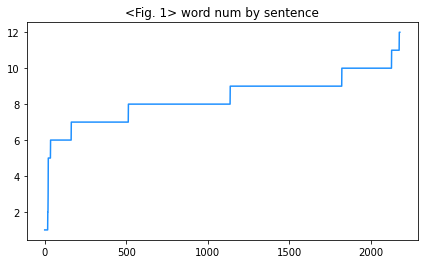

In [ ]:
sentence_len = [len(sentence.split(" ")) for sentence in corpus_sample]
sentence_len.sort()


cut_size = int(len(sentence_len) * 0.85)
print("*" * 50)
print("minimum word:", sentence_len[0])
print("maximum word:", sentence_len[-1])
print("85% word:", sentence_len[cut_size])
print("*" * 50)

# #14개 이하 단어로 구성된 문장으로 정제
# corpus = [sentence for sentence in corpus if len(sentence.split(" ")) < 15]


#시각화==========================
plt.figure(figsize=(7, 4))
plt.title("<Fig. 1> word num by sentence")
plt.plot(sentence_len, color="#1e90ff")
plt.show()

#End=================================


**하나의 단어로 이루어진 문장**

- 한 단어로 이루어진 데이터는 문장이 아닐 가능성이 크다. 따라서 이후의 전처리 과정에서 제외할 필요가 있다.


- 한 단어로 이루어진 데이터는 a개 이며, 아래는 한 단어로 이루어진 데이터 일부를 보여준다.

In [ ]:
one_word_sentence = {sentence for sentence in corpus_sample if len(sentence.split(" ")) == 1}

print("*" * 50)
for line in list(one_word_sentence)[10:15]:
    print(line, end="\n\n")
print("*" * 50)

print("\n*one word sentence num:", len(one_word_sentence))

**************************************************
**************************************************

*one word sentence num: 1



### 2.2. 단어 중심 데이터 분석


토큰 단위가 되는 단어를 중심으로 데이터를 분석한다. 

데이터에서 단어가 전체적으로 사용된 빈도와 단어의 길이 즉, 글자 개수를 살펴본다. 

데이터에서 사용된 단어는 총 a개 이다. 데이터에서 가장 많이 사용된 단어는 'i', 'the' 'you' 순으로 약 a회 정도 사용되었다. 


Fig. 2는 데이터에서 단어가 사용된 빈도를 보여준다. 

또한 단어의 글자 개수는 약 a ~ a개이다. 

하지만 글자 수가 a개 이상의 단어는 대체로 'owowowowowowowahhhh', 'yeahyeaheyeahhh' 등과 같이 감탄사 혹은 띄어쓰기가 되지 않은 단어의 빈도가 높다. 

따라서 이러한 점을 고려하여, 이후 전처리 시 제외 작업을 할 필요가 있다. Fig. 3은 단어 별 글자 개수를 보여준다.

**************************************************
*word num: 3116
**************************************************


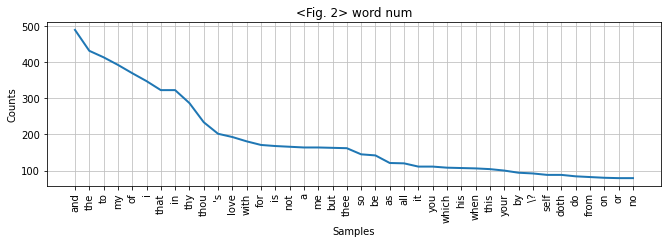

In [ ]:
word_list_dup = [word for sentence in corpus_sample for word in sentence.split(" ")]
word_list = {word for word in word_list_dup}
nltk_text = nltk.Text(word_list_dup)

print("*" * 50)
print("*word num:", len(word_list))
print("*" * 50)


plt.figure(figsize=(11, 3))
plt.title("<Fig. 2> word num")
nltk_text.plot(40)
plt.show()


**단어별 글자 개수**

- 대부분의 단어는 a ~ a개 사이의 글자로 이루어져있다.

- 그 이상의 단어는 감탄사나 띄어쓰기 하지 않은 단어로 이루어져있다.

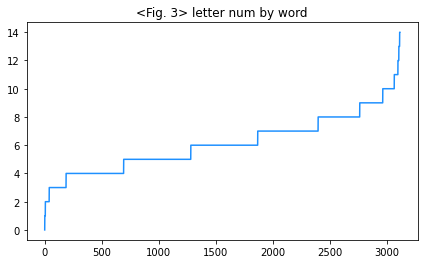

In [ ]:
word_len = [len(word) for word in word_list]
word_len.sort()

#시각화==========================
plt.figure(figsize=(7, 4))
plt.title("<Fig. 3> letter num by word")
plt.plot(word_len, color="#1e90ff")
plt.show()
#End=================================

In [ ]:
word_over_ten = [word for word in word_list if len(word) >= 15]

print("*" * 50)
for word in word_over_ten[:10]:
    print(word, end="\n\n")
print("*" * 50)

**************************************************
**************************************************




## 3. 데이터 전처리


앞서 학습 데이터로 사용될 데이터를 분석하였다. 

그 결과, a%의 문장이 단어 a개로 이루어져 있음을 확인하였다. 

또한, 한 개의 단어로 이루어진 데이터는 대부분 문장이 아님을 확인하였다. 

데이터에 사용된 단어는 a개이다. 단어는 약 a ~ a개의 글자로 되어있다.


이러한 분석을 바탕으로, 데이터 전처리는 다음과 같은 작업을 수행하고자 한다. 

단어가 a ~ a개로 이루어진 문장만을 데이터로 사용한다. 

글자 수가 a개 이상인 단어를 포함한 문장은 제외한다. 


전처리 과정을 거친 데이터는 총 a개의 문장과 a개의 단어로 구성된다.

In [ ]:
sample_corpus = None
corpus = []
for sentence in raw_corpus:
    if len(sentence) == 0: continue;   #길이가 0인 문장
    if sentence[-1] == ":": continue;   #문장의 끝이 ':'인 문장

    new_sentence = clean_str(sentence, TREC=False)

    if len(new_sentence.split(" ")) < 3: continue;   #단어가 2개 이하인 문장 제외
    if len(new_sentence.split(" ")) > 12: continue;   #토큰이 15개 이상인 문장
    
    #단어 중심===========
    letter_num_TF = True
    for word in new_sentence.split(" "):
        if len(word) > 14:   #글자 수 15개 이상 단어 제외
            letter_num_TF = False
            break
    if not letter_num_TF: continue
    #End=================
        
    new_sentence = "<start> " + new_sentence + " <end>"
    corpus.append(new_sentence)


**정제 데이터 정보**


- <start>와 <end> 토큰을 추가한 것을 확인할 수 있다.

- 총 문장 수는 a개, 단어 수는 a개 이다.


In [ ]:
word_list = {word for sentence in corpus for word in sentence.split(" ")}


#데이터 일부 출력========
print("*" * 50)
for line in corpus[10:15]:
    print(line, end="\n\n")
print("*" * 50)
#End======================


print("\n*sentence num:", len(corpus))
print("*word num:", len(word_list))

**************************************************
<start> pity the world or else this glutton be <end>

<start> to eat the world 's due by the grave and thee <end>

<start> when forty winters shall besiege thy brow <end>

<start> and dig deep trenches in thy beauty 's field <end>

<start> thy youth 's proud livery so gazed on now <end>

**************************************************

*sentence num: 2020
*word num: 2988


**데이터 토큰화**

- a개의 단어사전을 가진 토크나이저를 생성한다.

- 문장은 뒷 부분에 패딩을 추가한다.

In [ ]:
 #토크나이즈 함수======================================
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        oov_token="<unk>",   #포함되지 못한 단어는 "<unk>"로 처리
        filters=' '   #전처리되었으므로 제외
    )
    
    tokenizer.fit_on_texts(corpus)   #매개변수로 토크나이저 내부 단어장 생성
    tensor = tokenizer.texts_to_sequences(corpus)   #매개변수 Tensor로 변환
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding="post", maxlen = 15)
    return tensor, tokenizer
#End====================================================


tensor, tokenizer = tokenize(corpus)

print("*tensor shape:", tensor.shape)
print("\n*one_sample:", tensor[:1])

print("\n" + "*" * 50)
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])
    if idx >= 8: break
print("*" * 50)

*tensor shape: (2020, 15)

*one_sample: [[   2   36 1298 1299    3    0    0    0    0    0    0    0    0    0
     0]]

**************************************************
1 : <unk>
2 : <start>
3 : <end>
4 : and
5 : the
6 : my
7 : to
8 : of
**************************************************


**데이터셋 생성하기**

- train_test_split으로 데이터를 분리한 후, from_tensor_slices를 이용하여 데이터셋을 생성한다.

- 데이터셋 배치사이즈는 a로 설정한다.

In [ ]:
#학습데이터와 정답 데이터 분리하기
from sklearn.model_selection import train_test_split
src_input = tensor[:, :-1]   #마지막 토큰을 잘라내 소스문장 생성 => x_data
tgt_input = tensor[:, 1:]   #첫번째 idx인 <start>를 잘라내기 => target_data

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 2)

#텐서플로 데이터셋으로 만들기==============
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 32

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))   #tensor를 dataset으로 변환
# dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
#End=======================================

print("\n" + "*" * 50)
print("Source Train:", enc_train.shape)
print("Source val Train:", enc_val.shape)

print("\nTarget Train:", dec_train.shape)
print("Target val Train:", dec_val.shape)
print("*" * 50)


**************************************************
Source Train: (1616, 14)
Source val Train: (404, 14)

Target Train: (1616, 14)
Target val Train: (404, 14)
**************************************************




## 4. 모델 학습 및 평가


전처리를 거친 데이터를 바탕으로 모델을 학습 한다. 'Simple RNN', 'GRU', 'LSTM'에 대한 각 모델을 적용하여 학습을 진행한다. 

각 모델은 임베딩 레이어, RNN 레이어, a 비율의 드롭아웃 레이어, 배치정규화 레이어, 출력 레이어 순으로 설계하였으며, RNN 레이어의 유닛 수는 a개로 모두 동일하게 적용하였다. 

또한, 임베딩 사이즈는 a을 적용하였다.

<br>

옵티마이저로 Adam을 사용하였으며, 배치 사이즈를 a개로 설정하였다. 학습 epoch는 a로 설정하였다. 또한, 매 epoch 마다 'i', 'you', 'love'를 문장의 시작 단어로 입력하여 생성되는 문장을 확인하고자 한다.

**모델 생성 및 콜백, 문장 예측 함수**


- 자주 사용되는 모델 생성과 콜백, 문장 예측, 모델 학습 기능을 클래스 및 함수화하였다.

- 콜백 함수의 경우 모델 학습 시 매 epoch가 종료될 때, 문장 생성 예시를 출력한다.

In [ ]:
#모델 생성 클래스=================================
class TextGenerator(tf.keras.Model):
    def __init__(
            self,
            model_type, #"LSTM", "GRU", "RNN"
            vocab_size,   #단어사전 크기
        ):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, 500)
        
        if model_type == "LSTM":
            self.rnn_1 = tf.keras.layers.LSTM(2000, return_sequences=True)
        elif model_type == "GRU":
            self.rnn_1 = tf.keras.layers.GRU(2000, return_sequences=True)
        else:
            self.rnn_1 = tf.keras.layers.SimpleRNN(2000, return_sequences=True, activation="tanh")
            
        self.dropout_1 = tf.keras.layers.Dropout(rate=0.2)
        
        self.batnorm_1 = tf.keras.layers.BatchNormalization()
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.dropout_1(out)
        
        out = self.batnorm_1(out)
        out = self.linear(out)
        
        return out
#End==============================================
    
    
#문장 예측 함수====================================
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True:
        predict = model(test_tensor)
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]
        test_tensor = tf.concat(
            [test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1
        )
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "
    
    return generated
#End==============================================


#콜백 함수========================================
def train_model(epoch, logs):
    print("\n\n" + "*" * 25)
    words = ["i", "you", "love"]
    for init_word in words:
        sentence = generate_text(model, tokenizer, "<start> " + init_word, 15)
        print(sentence, end="\n\n")
    print("*" * 25)
    
testmodelcb = tf.keras.callbacks.LambdaCallback(on_epoch_end=train_model)
#End==============================================


#컴파일 및 학습 함수==============================
def compile_fit(model, callback_func):
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none'
    )

    model.compile(loss=loss, optimizer=optimizer)

    hist = model.fit(
        enc_train, dec_train, 
        epochs=4,
        batch_size=32,
        validation_data=(enc_val, dec_val),
        shuffle=True,
        callbacks=[callback_func],
        verbose=1
    )
    return None
#End==============================================

**input size 설정용 샘플 데이터**

- 모델의 입력 사이즈 설정을 위한 샘플 데이터 추출 과정

In [ ]:
for src_sample, _ in dataset.take(1): break   #dataset으로부터 하나의 데이터 받아오기



### 4.1 Simple RNN

Simple RNN은 순환 신경망의 기초적인 레이어이다. 과거에 대한 정보를 지속적으로 전달하여 시계열 등의 문제에 사용된다. 

<br>

Simple RNN의 경우 입력 데이터가 길어질수록 '장기의존성' 문제로 인해 성능이 저하되는 단점이 존재한다. 

본 예제에서는 a개의 유닛을 가진 Simple RNN 레이어를 사용하였다. 또한, 활성화 함수로 'tanh'를 사용하였다.

In [ ]:
model = TextGenerator(
    "SimpleRNN",
    tokenizer.num_words + 1,   #tokenizer.num_words: 단어사전 사이즈 + <pad>
)

model(src_sample)   #해당 데이터를 넣어줌으로써 모델 input_size 설정
model.summary()

Model: "text_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  6000500   
                                                                 
 simple_rnn (SimpleRNN)      multiple                  5002000   
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 batch_normalization (BatchN  multiple                 8000      
 ormalization)                                                   
                                                                 
 dense (Dense)               multiple                  24014001  
                                                                 
Total params: 35,024,501
Trainable params: 35,020,501
Non-trainable params: 4,000
____________________________________

**모델 학습 및 문장생성**


Simple RNN 모델의 학습 결과, epoch a 일 때 validation loss가 a로 성능이 가장 좋았다. 

Simple RNN 모델의 특징은 단어 사전에 등록되지 못한 토큰인 <unk>가 자주 사용된 다는 것이다.

또한, 해당 토큰이 주로 명사 부분에 사용되는 것을 확인할 수 있다. 

다음은 'I', 'You', 'Love'를 시작 단어로 주었을 때, Simple RNN 모델이 생성한 문장을 제시한 것이다.

In [ ]:
compile_fit(model, testmodelcb)


Epoch 1/4
50/51 [============================>.] - ETA: 0s - loss: 5.8372

*************************
<start> i love thee thee gave <end> 

<start> you love thee thee gave gave <end> 

<start> love love thee thee gave gave <end> 

*************************
51/51 [==============================] - 5s 54ms/step - loss: 5.8317 - val_loss: 5.6929
Epoch 2/4
50/51 [============================>.] - ETA: 0s - loss: 4.2883

*************************
<start> i 's 's 's 's 's <end> 

<start> you 's 's 's 's 's <end> 

<start> love 's 's 's 's 's <end> 

*************************
51/51 [==============================] - 3s 55ms/step - loss: 4.2881 - val_loss: 5.1231
Epoch 3/4
51/51 [==============================] - ETA: 0s - loss: 4.1582

*************************
<start> i i 's 's 's 's <end> 

<start> you i 's 's 's 's <end> 

<start> love i 's 's 's 's <end> 

*************************
51/51 [==============================] - 2s 47ms/step - loss: 4.1582 - val_loss: 5.2652
Epoch 4/4
51/51 [====


### 4.2 GRU
GRU는 RNN의 '장기의존성'에 관한 논문을 제시한 '요슈아 벤지오' 교수의 제자인 뉴욕대학교 '조경현' 교수 등이 제안한 구조이다

LSTM과 비슷한 기능을 하지만 구조가 간단하여 파라미터 수가 LSTM에 비해 적으며 특정 문제에서는 LSTM에 비해 좋은 성능을 보이기도 한다.



In [ ]:
model = TextGenerator(
    "GRU",
    tokenizer.num_words + 1,   #tokenizer.num_words: 단어사전 사이즈 + <pad>
)

model(src_sample)   #해당 데이터를 넣어줌으로써 모델 input_size 설정
model.summary()

Model: "text_generator_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  6000500   
                                                                 
 gru (GRU)                   multiple                  15012000  
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 batch_normalization_1 (Batc  multiple                 8000      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             multiple                  24014001  
                                                                 
Total params: 45,034,501
Trainable params: 45,030,501
Non-trainable params: 4,000
__________________________________

**모델 학습 및 문장생성**

GRU 모델의 학습 결과, epoch a 일 때 validation loss가 a로 성능이 가장 좋았다. 

하지만 생성한 문장은 오히려 epoch a의 경우가 더 명확하고 직관적이다. 

다음은 'I', 'You', 'Love'를 시작 단어로 주었을 때, GRU 모델이 생성한 문장을 제시한 것이다.

In [ ]:
compile_fit(model, testmodelcb)


Epoch 1/4
51/51 [==============================] - ETA: 0s - loss: 6.9130

*************************
<start> i <end> 

<start> you <end> 

<start> love <end> 

*************************
51/51 [==============================] - 6s 78ms/step - loss: 6.9130 - val_loss: 9.5923
Epoch 2/4
50/51 [============================>.] - ETA: 0s - loss: 3.9447

*************************
<start> i heart <end> 

<start> you <end> 

<start> love <end> 

*************************
51/51 [==============================] - 3s 54ms/step - loss: 3.9447 - val_loss: 6.0433
Epoch 3/4
50/51 [============================>.] - ETA: 0s - loss: 3.7101

*************************
<start> i beauty false false false <end> 

<start> you eye false false false <end> 

<start> love eye false false false <end> 

*************************
51/51 [==============================] - 3s 51ms/step - loss: 3.7101 - val_loss: 5.1638
Epoch 4/4
50/51 [============================>.] - ETA: 0s - loss: 3.4435

*************************
<s


### 4.3 LSTM
    
LSTM은 Simple RNN의 장기의존성 문제를 해결하기 위해 제안된 것으로, 유닛 간 상태를 보존하여 전달하는 것으로 해당 문제를 해결하였다. 


즉, 과거의 기억을 잊게 하고, 최근 기억을 많이 이용하게 하는 것이다

앞서 제시된 Simple RNN과 GRU에 비해 요구되는 파라미터 수가 큰 편이다.

In [ ]:
model = TextGenerator(
    "LSTM",
    tokenizer.num_words + 1,   #tokenizer.num_words: 단어사전 사이즈 + <pad>
)

model(src_sample)   #해당 데이터를 넣어줌으로써 모델 input_size 설정
model.summary()

Model: "text_generator_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  6000500   
                                                                 
 lstm (LSTM)                 multiple                  20008000  
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 batch_normalization_2 (Batc  multiple                 8000      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             multiple                  24014001  
                                                                 
Total params: 50,030,501
Trainable params: 50,026,501
Non-trainable params: 4,000
__________________________________


**모델 학습 및 문장생성**

LSTM 모델의 학습 결과, epoch a일 때 validation loss가 a 으로 성능이 가장 좋았다. 

다음은 'I', 'You', 'Love'를 시작 단어로 주었을 때, LSTM 모델이 생성한 문장을 제시한 것이다.


In [ ]:
compile_fit(model, testmodelcb)


Epoch 1/4
50/51 [============================>.] - ETA: 0s - loss: 4.8574

*************************
<start> i to to to the of <end> 

<start> you to to to the of <end> 

<start> love to to to the of <end> 

*************************
51/51 [==============================] - 6s 70ms/step - loss: 4.8556 - val_loss: 7.6601
Epoch 2/4
50/51 [============================>.] - ETA: 0s - loss: 3.8819

*************************
<start> i and and of of to <end> 

<start> you and and to of and <end> 

<start> love and and to and of <end> 

*************************
51/51 [==============================] - 3s 61ms/step - loss: 3.8815 - val_loss: 7.6192
Epoch 3/4
50/51 [============================>.] - ETA: 0s - loss: 3.5649

*************************
<start> i in my heart and <end> 

<start> you in my heart and in <end> 

<start> love and in my heart <end> 

*************************
51/51 [==============================] - 3s 59ms/step - loss: 3.5657 - val_loss: 7.3880
Epoch 4/4
50/51 [=========



## 결론


Simple RNN, GRU, LSTM을 사용한 문장생성 모델로부터 a 단어 이하로 구성된 문장을 출력하도록 하였다. 


validation loss가 가장 낮았던 모델은 LSTM을 사용한 모델이었으며, epoch a일 때, a이었다. 


Simple RNN의 경우 장기의존문제로 인해 학습이 의도대로 이루어지지 않았으며, 단어 사전에 포함되지 못한 토큰을 자주 출력하였다. 


또한, 해당 토큰을 명사 자리에 주로 사용한 것을 확인하였다. GRU의 경우 LSTM에 비해 validation loss가 높았지만, 그 차이는 미미했으며, 적은 파라미터를 사용하였음에도 불구하고 문장생성이 올바르게 이루어진것을 확인하였다. 

각 모델의 validation loss와 생성 문장을 제시한 것이다.

아래의 이미지처럼 결과를 적어주세요

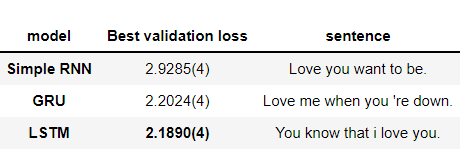